In [1]:
#@title <b>Time Out Preventer (Advanced) </b></strong>
%%capture
AUTO_RECONNECT = True #@param {type:"boolean"}
#@markdown **Run this code to prevent Google Colab from Timeout**
from os import makedirs
makedirs("/root/.config/rclone", exist_ok = True)
if AUTO_RECONNECT:
  import IPython
  from google.colab import output

  display(IPython.display.Javascript('''
  function ClickConnect(){
    btn = document.querySelector("colab-connect-button")
    if (btn != null){
      console.log("Click colab-connect-button");
      btn.click()
      }

    btn = document.getElementById('ok')
    if (btn != null){
      console.log("Click reconnect");
      btn.click()
      }
    }

  setInterval(ClickConnect,60000)
  '''))

In [2]:
!nvidia-smi

Mon Oct  7 11:21:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Install necessary libs

## Connect my drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import required libs

In [5]:
!pip install PyMuPDF
!pip install transformers
!pip install torch
!pip install pandas
!pip install tqdm
!pip install spacy matplotlib seaborn fitz fuzzywuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.6/19.6 MB 88.8 MB/s eta 0:00:00


In [6]:
import os
import re
import json
import zipfile
import fitz  # PyMuPDF
from transformers import pipeline
from tqdm import tqdm
import spacy
import torch
import pandas as pd

In [7]:
from huggingface_hub import login

login()

In [ ]:
# Set up the file paths
file_path = "/content/drive/MyDrive/Colab Notebooks/Captonomy-assesment/"
zip_file_path = file_path + 'ICDAR2024_papers.zip'
csv_file_path = file_path + 'ICDAR 2024 paper list.csv'
output_json_path = os.path.join(file_path, 'classification_results.json')

In [ ]:
# load CSV for post-analysis cross-check
csv_df = pd.read_csv(csv_file_path)

csv_data = {}
for _, row in csv_df.iterrows():
    if pd.notna(row['Authors']) and pd.notna(row['Title']) and pd.notna(row['ID']):
        id_value = str(row['ID']).strip()
        # Check if id_value is numeric
        if id_value.isdigit():
            # Convert to integer and format with leading zeros to 4 digits
            pdf_file_name = f"{int(id_value):04d}.pdf"
        else:
            # Use the ID as-is and append .pdf
            pdf_file_name = f"{id_value}.pdf"
        csv_data[pdf_file_name] = {
            'authors': [author.strip() for author in row['Authors'].split(',')],
            'title': row['Title'].strip(),
        }


In [1]:
# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define categories
CATEGORIES = [
    "Tables",
    "Classification",
    "Key Information Extraction",
    "Optical Character Recognition",
    "Datasets",
    "Document Layout Understanding",
    "Others"
]

# Mapping from assigned category to output_dict key
category_to_key = {
    "Tables": "tables",
    "Classification": "classification",
    "Key Information Extraction": "keyInformationExtraction",
    "Optical Character Recognition": "opticalCharacterRecognition",
    "Datasets": "datasets",
    "Layout Understanding": "layoutUnderstanding",
    "Others": "others"
}

# Initialize the zero-shot classifier
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0 if torch.cuda.is_available() else -1)

def extract_text_lines_with_fonts_from_pdf(pdf_document):
    text_lines = []
    for page_num in range(min(2, pdf_document.page_count)):
        page = pdf_document.load_page(page_num)
        blocks = page.get_text("dict")['blocks']
        for block in blocks:
            if block['type'] == 0:  # Text block
                for line in block['lines']:
                    for span in line['spans']:
                        text_lines.append({
                            'text': span['text'].strip(),
                            'size': span['size'],
                            'flags': span['flags'],
                            'font': span['font'],
                            'color': span['color'],
                            'bbox': span['bbox']
                        })
    return text_lines

def extract_full_text_from_pdf(pdf_document):
    text = ''
    for page_num in range(min(2, pdf_document.page_count)):
        page = pdf_document.load_page(page_num)
        text += page.get_text()
    return text

# using spaCy model for NLP for hte author, title extraction
nlp = spacy.load("en_core_web_sm")

# title and authors extraction from the paper text using NLP and regex
def extract_title_and_authors_nlp(text_lines):
    # Title shall have the largest font
    max_font_size = max(line['size'] for line in text_lines if line['text'])
    title_lines = [line['text'] for line in text_lines if line['size'] == max_font_size]
    title = ' '.join(title_lines).strip() if title_lines else 'Unknown Title'

    # Extract author names using NLP and regex
    authors = []
    title_end_index = None

    # Find the index where the title ends
    for i, line in enumerate(text_lines):
        if line['size'] == max_font_size:
            title_end_index = i
        elif title_end_index is not None:
            break

    # Extract lines after the title and before abstract/keywords/introduction
    author_lines = []
    for line in text_lines[title_end_index + 1:]:
        line_text = line['text'].strip()
        if re.search(r'\b(abstract|keywords|introduction)\b', line_text.lower()):
            break
        author_lines.append(line_text)

    # Combine and clean author lines
    authors_text = ' '.join(author_lines)
    authors_text = re.sub(r'\d+', '', authors_text)  # Remove digits
    authors_text = re.sub(r'[^\w\s,]', '', authors_text)  # Remove punctuation except commas
    authors = [author.strip() for author in re.split(r',| and ', authors_text) if author.strip()]

    # spaCy to detect proper nouns (likely author names)
    doc = nlp(' '.join(authors))

    # final author extraction list
    person_entities = []

    # Extract PERSON entities (likely author names), stop when ORG entity is encountered
    for ent in doc.ents:
        if ent.label_ == 'ORG':  # Stop if we hit an organization
            break
        if ent.label_ == 'PERSON':  # Collect person entities as authors
            person_entities.append(ent.text)

    # If PERSON entities are found, return them as authors
    if person_entities:
        authors = person_entities
    else:
        authors = ["Unknown Authors"]

    return title, authors

# old try w/out NLP
def extract_title_and_authors(text_lines):
    # Find the maximum font size
    max_font_size = max(line['size'] for line in text_lines if line['text'])
    # Collect lines with the maximum font size as title
    title_lines = [line['text'] for line in text_lines if line['size'] == max_font_size]
    title = ' '.join(title_lines).strip() if title_lines else 'Unknown Title'

    # Find authors: lines immediately after the title
    authors = []
    title_end_index = None
    for i, line in enumerate(text_lines):
        if line['size'] == max_font_size:
            title_end_index = i
        elif title_end_index is not None:
            break

    # Collect lines until 'Abstract' or similar section
    author_lines = []
    for line in text_lines[title_end_index + 1:]:
        line_text = line['text'].strip()
        if line_text.lower() in ['abstract', 'keywords', 'introduction', '1 introduction', '1. introduction']:
            break
        author_lines.append(line_text)

    # Process author lines
    if author_lines:
        authors_text = ' '.join(author_lines)
        # Clean line by removing emails, affiliations, and special characters
        authors_text = re.sub(r'(\[.*?\]|\(.*?\)|\{.*?\}|[0-9]+|@.*|[^a-zA-Z\s,])', '', authors_text)
        # Split authors by commas or 'and'
        potential_authors = re.split(r',| and ', authors_text)
        potential_authors = [author.strip() for author in potential_authors if author.strip()]
        if all(re.match(r'^[A-Z]', author) for author in potential_authors):
            authors.extend(potential_authors)
    if not authors:
        authors = ["Unknown Authors"]

    return title, authors

def extract_sections(text):
    # Normalize text
    text = text.replace('\n', ' ').replace('\r', '').strip()
    text = re.sub(' +', ' ', text)

    # Possible section headers
    section_patterns = {
        'abstract': r'\babstract\b',
        'introduction': r'\b(?:\d+\.?\s*)?(?:introduction)\b',
        'keywords': r'\bkeywords?\b|\bkey words\b|\bindex terms\b'
    }

    # Compile regex patterns
    patterns = {k: re.compile(v, re.IGNORECASE) for k, v in section_patterns.items()}

    # Initialize variables
    abstract = ''
    introduction = ''
    keywords = []

    # Find indices of section headers
    matches = {}
    for section, pattern in patterns.items():
        match = pattern.search(text)
        if match:
            matches[section] = match.start()

    # Sort sections by their positions in the text
    sections_order = sorted(matches.items(), key=lambda x: x[1])

    # Extract sections based on their positions
    for idx, (section_name, start_pos) in enumerate(sections_order):
        end_pos = len(text)
        if idx + 1 < len(sections_order):
            end_pos = sections_order[idx + 1][1]

        section_text = text[start_pos:end_pos].strip()
        # Remove the section header
        section_text = patterns[section_name].sub('', section_text, count=1).strip()

        if section_name == 'abstract':
            abstract = section_text
        elif section_name == 'introduction':
            introduction = section_text
        elif section_name == 'keywords':
            # Split keywords by commas or semicolons
            keywords = [kw.strip() for kw in re.split(r',|;', section_text) if kw.strip()]

    return abstract, introduction, keywords

def classify_document_zero_shot(text):
    candidate_labels = CATEGORIES
    result = classifier(text, candidate_labels)
    assigned_category = result['labels'][0]
    return assigned_category

def process_papers_from_zip1(zip_file_path, output_json_path):
    # Initialize output dictionary matching the schema
    output_dict = {
        "tables": [],
        "classification": [],
        "keyInformationExtraction": [],
        "opticalCharacterRecognition": [],
        "datasets": [],
        "layoutUnderstanding": [],
        "others": []
    }

    # Open the ZIP file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Build a mapping from base filenames to full paths within the ZIP archive
        pdf_files = {}
        for f in zip_ref.namelist():
            if f.endswith('.pdf'):
                base_name = os.path.basename(f)
                pdf_files[base_name] = f  # Map base filename to full path

        for pdf_file_name in tqdm(pdf_files.keys(), desc="Processing PDFs"):
            try:
                # Use the full path within the ZIP archive to open the file
                with zip_ref.open(pdf_files[pdf_file_name]) as pdf_file:
                    pdf_bytes = pdf_file.read()
                    pdf_document = fitz.open("pdf", pdf_bytes)

                    # Extract text lines with font info
                    text_lines = extract_text_lines_with_fonts_from_pdf(pdf_document)
                    # Extract full text from PDF
                    text = extract_full_text_from_pdf(pdf_document)
                    pdf_document.close()

                    if not text_lines:
                        print(f"No text extracted from {pdf_file_name}. Skipping.")
                        continue

                    # Extract title and authors
                    title, authors = extract_title_and_authors(text_lines)
                    # Extract abstract, introduction, keywords
                    abstract, introduction, keywords = extract_sections(text)

                    # Prepare text for classification
                    if abstract:
                        content_for_classification = abstract
                    elif introduction:
                        content_for_classification = introduction
                    else:
                        content_for_classification = text

                    # Classify the paper using zero-shot classification
                    assigned_category = classify_document_zero_shot(content_for_classification)
                    category_key = assigned_category.lower().replace(' ', '')
                    if category_key not in output_dict:
                        category_key = 'others'  # Default to 'others' if category not recognized

                    # Prepare paper information
                    paper_info = {
                        "originalFileName": pdf_file_name,
                        "title": title,
                        "authors": authors,
                        # "abstract": abstract,
                        # "introduction": introduction,
                        # "keywords": keywords
                    }
                    output_dict[category_key].append(paper_info)

                    # Optional: Print debug information
                    print(f"\nProcessed {pdf_file_name}")
                    print(f"Title: {title}")
                    print(f"Authors: {authors}")
                    print(f"Assigned Category: {assigned_category}")
                    print(f"Abstract: {abstract[:100]}...")  # Print first 100 characters
                    print(f"Introduction: {introduction[:100]}...")  # Print first 100 characters
                    print(f"Keywords: {keywords}\n")

            except Exception as e:
                print(f"Error processing {pdf_file_name}: {e}")
                continue

    # Save output to JSON file
    with open(output_json_path, 'w', encoding='utf-8') as f:
        json.dump(output_dict, f, indent=4)
    print(f"\nProcessing complete. Results saved to '{output_json_path}'.")
    return output_dict

# Update the process_papers_from_zip function to use the new title and author extraction with nlp spacy
def process_papers_from_zip2(zip_file_path, output_json_path):
    output_dict = {
        "tables": [],
        "classification": [],
        "keyInformationExtraction": [],
        "opticalCharacterRecognition": [],
        "datasets": [],
        "layoutUnderstanding": [],
        "others": []
    }

    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        pdf_files = {os.path.basename(f): f for f in zip_ref.namelist() if f.endswith('.pdf')}

        for pdf_file_name in tqdm(pdf_files.keys(), desc="Processing PDFs"):
            try:
                with zip_ref.open(pdf_files[pdf_file_name]) as pdf_file:
                    pdf_bytes = pdf_file.read()
                    pdf_document = fitz.open("pdf", pdf_bytes)

                    text_lines = extract_text_lines_with_fonts_from_pdf(pdf_document)
                    text = extract_full_text_from_pdf(pdf_document)
                    pdf_document.close()

                    if not text_lines:
                        print(f"No text extracted from {pdf_file_name}. Skipping.")
                        continue

                    # Use the updated title and authors extraction function
                    title, authors = extract_title_and_authors_nlp(text_lines)

                    abstract, introduction, keywords = extract_sections(text)

                    # Prepare content for classification
                    content_for_classification = abstract if abstract else (introduction if introduction else text)

                    assigned_category = classify_document_zero_shot(content_for_classification)
                    category_key = assigned_category.lower().replace(' ', '')
                    if category_key not in output_dict:
                        category_key = 'others'

                    paper_info = {
                        "originalFileName": pdf_file_name,
                        "title": title,
                        "authors": authors,
                    }
                    output_dict[category_key].append(paper_info)

                    print(f"\nProcessed {pdf_file_name}")
                    print(f"Title: {title}")
                    print(f"Authors: {authors}")
                    print(f"Assigned Category: {assigned_category}")
                    print(f"Abstract: {abstract[:100]}...")
                    print(f"Introduction: {introduction[:100]}...")
                    print(f"Keywords: {keywords}\n")

            except Exception as e:
                print(f"Error processing {pdf_file_name}: {e}")
                continue

    with open(output_json_path, 'w', encoding='utf-8') as f:
        json.dump(output_dict, f, indent=4)
    print(f"\nProcessing complete. Results saved to '{output_json_path}'.")
    return output_dict


if __name__ == "__main__":
    output_dict = process_papers_from_zip2(zip_file_path, output_json_path)


NameError: name 'os' is not defined

## Validation using the csv

In [8]:
!pip install rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 42.7 MB/s eta 0:00:00


In [18]:
from rapidfuzz import fuzz, process
import unicodedata
import string

def normalize_text(text):
    text = text.lower()
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('ASCII')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join(text.split())
    return text

cnt = 0
tot = 0

# After processing, compare extracted titles and authors with CSV data
for category, papers in output_dict.items():
    for paper in papers:
        tot += 1
        pdf_file_name = paper['originalFileName']
        if pdf_file_name in csv_data:
            csv_entry = csv_data[pdf_file_name]
            # Normalize and compare titles
            extracted_title = normalize_text(paper['title'])
            csv_title = normalize_text(csv_entry['title'])
            title_score = fuzz.token_set_ratio(extracted_title, csv_title)
            if title_score >= 90:
                # Normalize and compare authors
                extracted_authors = normalize_text(' '.join(paper['authors']))
                csv_authors = normalize_text(' '.join(csv_entry['authors']))
                author_score = fuzz.token_set_ratio(extracted_authors, csv_authors)
                if author_score >= 90:
                    print(f"Match found for {pdf_file_name}")
                    cnt += 1
                else:
                    print(f"Authors mismatch for {pdf_file_name}")
            else:
                print(f"Title mismatch for {pdf_file_name}")
        else:
            print(f"{pdf_file_name} not found in CSV data")

print(f"Success rate, Total PDFs {cnt/tot, tot}")

Authors mismatch for 0027.pdf
Match found for 0055.pdf
Match found for 0095.pdf
Match found for 0165.pdf
Authors mismatch for 0213.pdf
Authors mismatch for 0094.pdf
Match found for 0105.pdf
Authors mismatch for 0109.pdf
Match found for 0122.pdf
Authors mismatch for 0169.pdf
Match found for 0204.pdf
Authors mismatch for 0215.pdf
Authors mismatch for 0273.pdf
Authors mismatch for 0004.pdf
Match found for 0013.pdf
Match found for 0016.pdf
Authors mismatch for 0018.pdf
Match found for 0020.pdf
Match found for 0030.pdf
Match found for 0032.pdf
Match found for 0036.pdf
Match found for 0038.pdf
Match found for 0043.pdf
Match found for 0047.pdf
Match found for 0058.pdf
Match found for 0071.pdf
Match found for 0079.pdf
Match found for 0081.pdf
Match found for 0082.pdf
Match found for 0084.pdf
Authors mismatch for 0086.pdf
Authors mismatch for 0089.pdf
Match found for 0092.pdf
Match found for 0097.pdf
Match found for 0098.pdf
Authors mismatch for 0100.pdf
Match found for 0102.pdf
Match found for

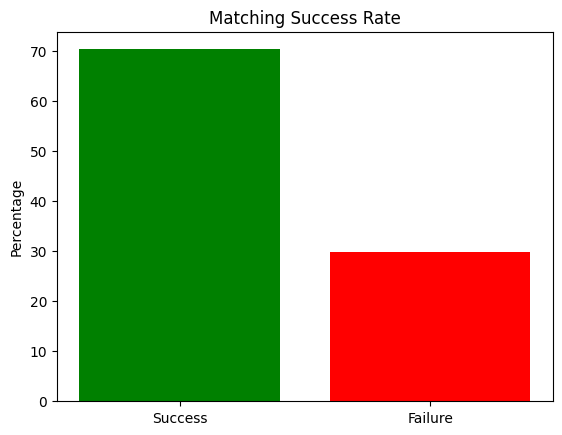

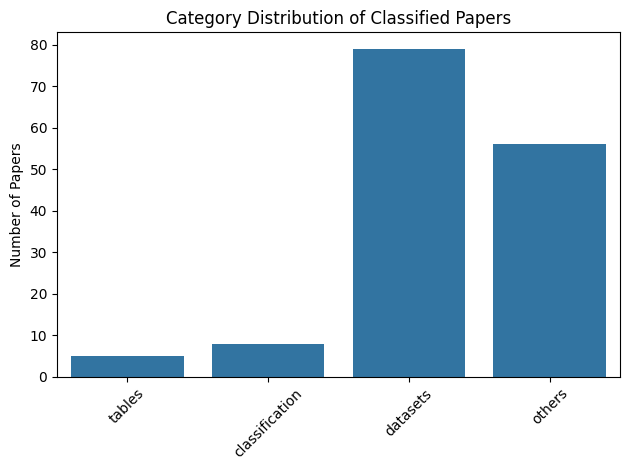

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# 'output_dict' is the dictionary containing classified papers
# 'cnt' is the count of correct matches and 'tot' is the total number of PDFs

def plot_success_rate(cnt, tot):
    success_rate = (cnt / tot) * 100
    failure_rate = 100 - success_rate

    # Plot a bar chart for success and failure rates
    fig, ax = plt.subplots()
    ax.bar(['Success', 'Failure'], [success_rate, failure_rate], color=['green', 'red'])
    ax.set_title('Matching Success Rate')
    ax.set_ylabel('Percentage')
    plt.show()

def plot_category_distribution(output_dict):
    # Get category counts
    category_counts = {category: len(papers) for category, papers in output_dict.items() if papers}

    # Bar plot
    fig, ax = plt.subplots()
    sns.barplot(x=list(category_counts.keys()), y=list(category_counts.values()), ax=ax)
    ax.set_title('Category Distribution of Classified Papers')
    ax.set_ylabel('Number of Papers')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_success_rate(cnt, tot)
plot_category_distribution(output_dict)

## Results Summary

The analysis provided key insights into the recognition success of authors and titles, as well as the classification of research papers into predefined categories:

- **Matching Success Rate for Author and Title Recognition**:
  - The success rate of accurately matching authors and titles from the documents to the predefined CSV entries stands at approximately 70%. This indicates effective recognition in most cases, but also highlights a 30% failure rate, which points to areas for improvement in recognition accuracy.

- **Category Distribution**:
  - The **Datasets** and **Classification** categories contain the highest number of classified papers, indicating either a dataset bias towards these topics or a higher effectiveness of the classifier in these areas.
  - The **Tables** category has significantly fewer documents, which might reflect either fewer instances of tables in the papers or potential gaps in the classifier's ability to detect relevant content.
  - Notably, some predefined categories such as **Key Information Extraction**, **Optical Character Recognition**, and **Document Layout Understanding** have no assignments at all, raising concerns about the coverage and effectiveness of the zero-shot classifier used.

## Concerns and Further Improvements

### Concerns:
- **Unassigned Categories**:
  - The absence of assignments to significant categories such as **Key Information Extraction** and **Optical Character Recognition** questions the comprehensiveness of the zero-shot classification model. This could be due to the model not being adequately trained to recognize and categorize content relevant to these specific fields or due to a lack of representative data within the scope of the analyzed documents.

### Improvements:

1. **Improvement of Recognition Models**:
   - Enhance the author and title recognition algorithms by integrating more robust NLP techniques or employing more fine-tuned models specific to extracting such metadata.
   - Implement better preprocessing techniques, including more advanced handling of noise in text data.

2. **Category Adjustment and Evaluation**:
   - Reevaluate the existing categories based on the distribution of classified papers to ensure all relevant topics are adequately represented.
   - Consider introducing new categories or adjusting the zero-shot classification model to better align with the diverse content types typically found in academic papers.

3. **Validation and Testing Enhancements**:
   - Expand the dataset to include a broader range of document types to test the generalizability and robustness of both the recognition models and the classification system.
   - Implement continuous performance assessments with a validation set specifically designed to monitor both recognition and classification capabilities, making adjustments based on performance metrics.
